<a href="https://colab.research.google.com/github/Redskywalker7/Charles-Reep/blob/main/data_collection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instructions



1.   Follow [this link](https://drive.google.com/drive/folders/1IXs4GWdfV3NPgxt6ue8EPjVXdPeKTNH6?usp=sharing) to access the statsbomb data folder:


    
2.   Once you have access to the shared folder, right-click on the folder name and select "Add shortcut to Drive" (see image below)
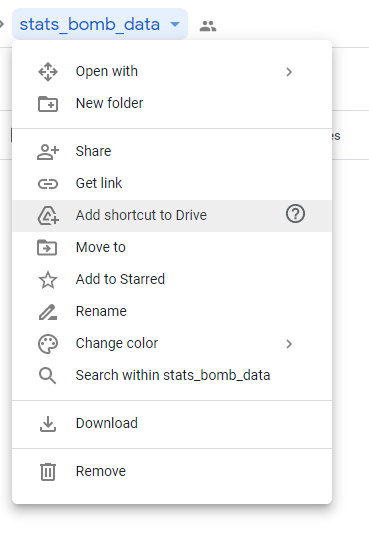

3. Run the code block below these instructions to bring the statsbomb data into the notebook

In [ ]:
#load the statsbomb data into the notebook here:
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

#access the data here:
import os
path = '/content/drive/MyDrive/stats_bomb_data/la_liga_events/'

Mounted at /content/drive


# Functions

In [ ]:
def open_json_file(relative_file_path, file_name):
    import json
    file = open(relative_file_path + file_name, encoding='utf-8')
    data = json.load(file)
    return data

In [ ]:
#we'll load all formation data into a dictionary and then load it into a pandas dataframe
def get_formation_data(data, file_name_without_extention_type, home_or_away):
    formation_data_dictionary = {"Match ID":[], "Team ID":[], "Team Name":[], "Formation":[], 
                                 "Period":[], "Timestamp":[], "Shots_tg":[], "Shots_tg_against":[],
                                 "Total_xg":[], "Total_xg_against":[], "Mean_xg":[],"Mean_xg_against":[], 
                                 "Goals":[], "Goals_against":[], "xg_per_minute":[], "xg_per_minute_against":[], 
                                 "pass_accuracy":[], "pass_accuracy_against":[], "possession_ratio":[], "possession_ratio_against":[]};

    if (home_or_away == 'home'):
      team_id = str(data[0]['team']['id'])
      team_name = data[0]['team']['name']
      curr_formation = str(data[0]['tactics']['formation'])
      curr_formation_period = data[0]['period']
      curr_formation_timestamp = data[0]['timestamp']
    else:
      team_id = str(data[1]['team']['id'])
      team_name = data[1]['team']['name']
      curr_formation = str(data[1]['tactics']['formation'])
      curr_formation_period = data[1]['period']
      curr_formation_timestamp = data[1]['timestamp']
    
    # Deciding who started with possession to use in our possession_ratio attribute
    if (data[5]['possession_team']['name'] == team_name):
      team_possession_flag = True
      poss_start_time = convert_timestamp_to_min(curr_formation_timestamp)

      team_possession_flag_against = False
    else:
      team_possession_flag = False
      
      team_possession_flag_against = True
      poss_start_time_against = convert_timestamp_to_min(curr_formation_timestamp)

    # Attacking Success Indicators
    poss_start_time = 0
    poss_end_time = 0
    possession_ratio = 0
    total_poss_time = 0
    num_pass_complete = 0
    total_num_pass = 0
    pass_ratio = 0
    curr_shots_tg = 0
    curr_form_xg = 0
    curr_form_meanxg = 0
    curr_form_goals = int(0)
    form_duration_in_min = 0
    number_shots = 0
    xg_per_minute = 0
    shots_on_target = ["Saved", "Goal", "Saved To Post"]

    # Defensive Success Indicators
    possession_ratio_against = 0
    curr_form_xg_against = 0
    curr_form_meanxg_against = 0
    curr_form_goals_against = 0
    curr_shots_tg_against = 0
    total_num_pass_against = 0
    num_pass_complete_against = 0
    number_shots_against = 0
    pass_ratio_against = 0
    xg_per_minute_against = 0

    
    
    for event in data:
      #For every shot event, add up the total xg per formation
      if (event['type']['name'] == 'Shot'):

        if (event["team"]["name"] == team_name):
          curr_form_xg += event['shot']['statsbomb_xg']
          number_shots += 1.0
          # For every goal scored, add to total goals
          if (event["shot"]["outcome"]["name"] == "Goal"):
            curr_form_goals += int(1)
          # Calculate to shots on target if event outcome is shot on target
          if (event["shot"]["outcome"]["name"] in shots_on_target):
            curr_shots_tg += 1
      
      #FOR OPPOSING TEAM
        else: #(event["team"]["name"] != team_name):
          curr_form_xg_against += event['shot']['statsbomb_xg']
          number_shots_against += 1.0
          # For every goal scored, add to total goals
          if (event["shot"]["outcome"]["name"] == "Goal"):
            curr_form_goals_against += int(1)
          # Calculate to shots on target if event outcome is shot on target
          if (event["shot"]["outcome"]["name"] in shots_on_target):
            curr_shots_tg_against += 1

      if (event['type']['name'] == 'Pass'):
        if (event["team"]["name"] == team_name):
          total_num_pass += 1
          if "outcome" in (event['pass']):
            num_pass_complete += 1
        #FOR OPPOSING TEAM
        else: 
          total_num_pass_against += 1
          if "outcome" in (event['pass']):
            num_pass_complete_against += 1
          
      # Find possession time
      if (event["possession_team"]["name"] == team_name):
        if (team_possession_flag == False):
          # Start of Possession Time in Minutes
          if (str(event["period"]) == "2"):
            poss_start_time = convert_timestamp_to_min(event['timestamp']) + 45
          else:
            poss_start_time = convert_timestamp_to_min(event['timestamp'])
          team_possession_flag = True
      else:
        if (team_possession_flag == True):
          #End of possession time in minutes
          if (str(event["period"]) == "2"):
            poss_end_time = convert_timestamp_to_min(event['timestamp']) + 45
          else:
            poss_end_time = convert_timestamp_to_min(event['timestamp'])
          team_possession_flag = False
          # Add possession length to total possession time 
          total_poss_time += (poss_end_time - poss_start_time)


      # Find every time the team makes a tactical shift record their results and new formation data
      # Include the very last formation used in the game
      if (event['type']['name'] == 'Tactical Shift'):

        # Team Formation Changes
        if (event["team"]["name"] == team_name):
          if (curr_formation != str(event["tactics"]["formation"])): 
            
            # Deterine How long the team was using the formation
            if (curr_formation_period == "2"):
              beginning_time = convert_timestamp_to_min(curr_formation_timestamp) + 45
            else:
              beginning_time = convert_timestamp_to_min(curr_formation_timestamp)
              
            if (str(event["period"]) == "2"):
              end_time = convert_timestamp_to_min(event["timestamp"]) + 45
            else:
              end_time = convert_timestamp_to_min(event["timestamp"])

            form_duration_in_min = (end_time - beginning_time)

            # Calculate mean xg by dividing xg by number of shots 
            if (number_shots > 0): 
              curr_form_meanxg = curr_form_xg/number_shots 
            if (number_shots_against > 0):
              curr_form_meanxg_against = curr_form_xg_against/number_shots_against
            
            # Calculate % of completed passes for and against
            if (total_num_pass > 0):
              pass_ratio = num_pass_complete/total_num_pass
            if (total_num_pass_against > 0):
              pass_ratio_against = num_pass_complete_against/total_num_pass_against

             
            if (form_duration_in_min > 0):
              # Calculate xg_per_minute
              xg_per_minute = curr_form_xg/form_duration_in_min
              xg_per_minute_against = curr_form_xg_against/form_duration_in_min

              # Calculate total possession time
              possession_ratio = total_poss_time/form_duration_in_min
              possession_ratio_against = 1 - possession_ratio

            formation_data_dictionary = add_row_to_formation_dictionary(formation_data_dictionary,
                                                                          file_name_without_extention_type,
                                                                          team_id, 
                                                                          team_name,
                                                                          curr_formation,
                                                                          curr_formation_period,
                                                                          curr_formation_timestamp,
                                                                          curr_shots_tg,
                                                                          curr_shots_tg_against,
                                                                          curr_form_xg,
                                                                          curr_form_xg_against,
                                                                          curr_form_meanxg,
                                                                          curr_form_meanxg_against,
                                                                          curr_form_goals,
                                                                          curr_form_goals_against,
                                                                          xg_per_minute,
                                                                          xg_per_minute_against,
                                                                          pass_ratio, 
                                                                          pass_ratio_against,
                                                                          possession_ratio,
                                                                          possession_ratio_against)

            #Set new formation parameters
            curr_formation = str(event["tactics"]["formation"])
            curr_formation_period = str(event["period"])
            curr_formation_timestamp = event["timestamp"]
            curr_shots_tg = 0
            curr_form_xg = 0
            curr_form_meanxg = 0
            curr_form_goals = int(0)
            number_shots = 0
            num_pass_complete = 0
            total_num_pass = 0
            pass_ratio = 0
            curr_shots_tg_against = 0
            curr_form_xg_against = 0
            curr_form_meanxg_against = 0
            curr_form_goals_against = int(0)
            number_shots_against = 0
            num_pass_complete_against = 0
            total_num_pass_against = 0
            pass_ratio_against = 0
            total_poss_time = 0
            total_poss_time_against = 0
            possession_ratio = 0
            possession_ratio_against = 0



        # Include the formations the teams ended with
      elif (event['type']['name'] == 'Half End' and str(event['period']) == '2'):
        # End-of-game formation data
        if (event["team"]["name"] == team_name):

          if (curr_formation_period == "2"):
            beginning_time = convert_timestamp_to_min(curr_formation_timestamp) + 45
          else:
            beginning_time = convert_timestamp_to_min(curr_formation_timestamp)
            
          if (str(event["period"]) == "2"):
            end_time = convert_timestamp_to_min(event["timestamp"]) + 45
          else:
            end_time = convert_timestamp_to_min(event["timestamp"])

          form_duration_in_min = (end_time - beginning_time)
            
          # Calculate mean xg by dividing xg by number of shots for and against
          if (number_shots > 0): 
            curr_form_meanxg = curr_form_xg/number_shots 
          if (number_shots_against > 0):
            curr_form_meanxg_against = curr_form_xg_against/number_shots_against

          # Calculate % of completed passes for and against
          if (total_num_pass > 0):
              pass_ratio = num_pass_complete/total_num_pass
          if (total_num_pass_against > 0):
            pass_ratio_against = num_pass_complete_against/total_num_pass_against

          # Calculate xg_per_minute
          if (form_duration_in_min > 0):
            xg_per_minute = curr_form_xg/form_duration_in_min
            xg_per_minute_against = curr_form_xg_against/form_duration_in_min

            # Calculate total possession time
            possession_ratio = total_poss_time/form_duration_in_min
            possession_ratio_against = 1 - possession_ratio

          formation_data_dictionary = add_row_to_formation_dictionary(formation_data_dictionary,
                                                                          file_name_without_extention_type,
                                                                          team_id, 
                                                                          team_name,
                                                                          curr_formation,
                                                                          curr_formation_period,
                                                                          curr_formation_timestamp,
                                                                          curr_shots_tg,
                                                                          curr_shots_tg_against,
                                                                          curr_form_xg,
                                                                          curr_form_xg_against,
                                                                          curr_form_meanxg,
                                                                          curr_form_meanxg_against,
                                                                          curr_form_goals,
                                                                          curr_form_goals_against,
                                                                          xg_per_minute,
                                                                          xg_per_minute_against,
                                                                          pass_ratio, 
                                                                          pass_ratio_against,
                                                                          possession_ratio,
                                                                          possession_ratio_against)

    return formation_data_dictionary

In [ ]:
#this is for our shots per formation visualizations
def get_shots_per_formation(data, file_name_without_extention_type, home_or_away):
    dictionary = {"Event_ID":[], "Match_ID":[], "Team_ID":[], "Team_Name":[], "Formation":[], 
                                 "Location_X":[], "Location_Y":[], "Outcome":[], "For_or_Against":[]};

    if (home_or_away == 'home'):
      team_id = str(data[0]['team']['id'])
      team_name = data[0]['team']['name']
      curr_formation = str(data[0]['tactics']['formation'])
    else:
      team_id = str(data[1]['team']['id'])
      team_name = data[1]['team']['name']
      curr_formation = str(data[1]['tactics']['formation'])

    
    
    for event in data:
      #For every shot event, insert a new row into the CSV
      if (event['type']['name'] == 'Shot'):

        if (event["team"]["name"] == team_name):
          for_or_against = "For"
        #FOR OPPOSING TEAM
        else:
          for_or_against = "Against"

        event_id = event["id"]
        match_id = file_name_without_extention_type
        location_x = event["location"][0]
        location_y = event["location"][1]
        outcome = event["shot"]["outcome"]["name"]

        dictionary["Event_ID"].append(event_id)
        dictionary["Match_ID"].append(match_id)
        dictionary["Team_ID"].append(team_id)
        dictionary["Team_Name"].append(team_name)
        dictionary["Formation"].append(curr_formation)
        dictionary["Location_X"].append(location_x)
        dictionary["Location_Y"].append(location_y)
        dictionary["Outcome"].append(outcome)
        dictionary["For_or_Against"].append(for_or_against)

      # Find every time the team makes a tactical shift record their new formation
      if (event['type']['name'] == 'Tactical Shift'):

        # Team Formation Changes
        if (event["team"]["name"] == team_name):
          if (curr_formation != str(event["tactics"]["formation"])): 

            #Set new formation parameters
            curr_formation = str(event["tactics"]["formation"])

    return dictionary

In [ ]:
def add_row_to_formation_dictionary(dictionary, match_id, team_id, team_name, formation, period,
                                   timestamp, Shots_tg, Shots_tg_against,
                                    total_xg, total_xg_against, total_meanxg, total_meanxg_against, goals, goals_against, 
                                    xg_per_minute, xg_per_minute_against, pass_accuracy, pass_accuracy_against, possession_ratio, possession_ratio_against):
  
  dictionary["Match ID"].append(match_id)
  dictionary["Team ID"].append(team_id)
  dictionary["Team Name"].append(team_name)
  dictionary["Formation"].append(formation)
  dictionary["Period"].append(period)
  dictionary["Timestamp"].append(timestamp)
  dictionary["Shots_tg"].append(Shots_tg)
  dictionary["Shots_tg_against"].append(Shots_tg_against)
  dictionary["Total_xg"].append(total_xg)
  dictionary["Total_xg_against"].append(total_xg_against)
  dictionary["Mean_xg"].append(total_meanxg)
  dictionary["Mean_xg_against"].append(total_meanxg_against)
  dictionary["Goals"].append(goals)
  dictionary["Goals_against"].append(goals_against)
  dictionary["xg_per_minute"].append(xg_per_minute)
  dictionary["xg_per_minute_against"].append(xg_per_minute_against)
  dictionary["pass_accuracy"].append(pass_accuracy)
  dictionary["pass_accuracy_against"].append(pass_accuracy_against)
  dictionary["possession_ratio"].append(possession_ratio)
  dictionary["possession_ratio_against"].append(possession_ratio_against)

  return dictionary

In [ ]:
def convert_timestamp_to_min(msf):
    hours, minutes, seconds = msf.split(':')
    seconds, milliseconds = seconds.split('.')
    minutes, seconds, milliseconds = map(int, (minutes, seconds, milliseconds))
    return minutes + (seconds/60) + (milliseconds/60000)

In [ ]:
def data_to_dataframe(dictionary):
    import pandas as pd
    dataframe = pd.DataFrame(dictionary)
    return dataframe

# Run

In [ ]:
# Loop through json files in json folder and append to csv
import pandas as pd

full_events_columns = {"Match ID":[], "Team ID":[], "Team Name":[], "Formation":[], 
                       "Period":[], "Timestamp":[], "Shots_tg":[], 
                       "Total_xg":[], "Mean_xg":[], "Goals":[]};

full_events = pd.DataFrame(full_events_columns)

for file_name in os.listdir(path):
  if file_name[-5:] == ".json":
    data = open_json_file(path, file_name)
    home_output = get_formation_data(data, file_name.partition(".")[0], 'home')
    away_output = get_formation_data(data, file_name.partition(".")[0], 'away')
    home_formation_dataframe = data_to_dataframe(home_output)
    away_formation_dataframe = data_to_dataframe(away_output)
    full_events = full_events.append(home_formation_dataframe, ignore_index=True)
    full_events = full_events.append(away_formation_dataframe, ignore_index=True)


In [ ]:
# Loop through json files in json folder and append to csv
import pandas as pd

shots_per_formation_columns = {"Event_ID":[], "Match_ID":[], "Team_ID":[], "Team_Name":[], "Formation":[], 
                                 "Location_X":[], "Location_Y":[], "Outcome":[], "For_or_Against":[]};

shots_per_formation_data = pd.DataFrame(shots_per_formation_columns)

for file_name in os.listdir(path):
  if file_name[-5:] == ".json":
    data = open_json_file(path, file_name)
    home_output = get_shots_per_formation(data, file_name.partition(".")[0], 'home')
    away_output = get_shots_per_formation(data, file_name.partition(".")[0], 'away')
    home_formation_dataframe = data_to_dataframe(home_output)
    away_formation_dataframe = data_to_dataframe(away_output)
    shots_per_formation_data = shots_per_formation_data.append(home_formation_dataframe, ignore_index=True)
    shots_per_formation_data = shots_per_formation_data.append(away_formation_dataframe, ignore_index=True)


In [ ]:
shots_per_formation_data

,Event_ID,Match_ID,Team_ID,Team_Name,Formation,Location_X,Location_Y,Outcome,For_or_Against
0,08079c96-d10e-4f08-8e55-cd436c8a4224,265837,210,Real Sociedad,4231,88.3,44.0,Saved,For
1,8a4f7c14-6dfd-4e46-98b9-95da6a721d14,265837,210,Real Sociedad,4231,103.5,34.9,Off T,Against
2,8e493d8c-13b0-45fa-9e76-cb2c7f5c98a6,265837,210,Real Sociedad,4231,101.8,29.9,Off T,For
3,331bb91d-dfaf-41ab-adb1-89022f9bd430,265837,210,Real Sociedad,4231,101.0,38.7,Goal,Against
4,ea09cd86-ccc9-417f-ac8c-850319dacfab,265837,210,Real Sociedad,4231,111.0,48.8,Off T,For
...,...,...,...,...,...,...,...,...,...
24001,14808dff-6f20-468f-987b-4c237edf7bf8,9682,217,Barcelona,442,94.9,32.7,Saved,For
24002,13723f74-d57b-4bf2-ba52-ec5fea376912,9682,217,Barcelona,442,112.3,27.4,Saved,For
24003,d87fe0fc-621b-44c2-8f25-9a3bb176fde1,9682,217,Barcelona,442,116.7,29.5,Blocked,For
24004,81ffc57e-7cd8-494b-9fcd-a58b3937350e,9682,217,Barcelona,442,113.7,33.5,Goal,For


In [ ]:
shots_per_formation_data.to_csv('/content/drive/MyDrive/stats_bomb_data/la_liga_shots_per_formation.csv')